# Stage direction classification : scikit-learn algorithms

In [1]:
%matplotlib inline

# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import metrics, set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

# Pour éviter l'affichage tronqué des descriptions
pd.set_option('display.max_colwidth', -1) 
# Pour la visualisation des pipelines sklearn
set_config(display='diagram') 

Generic statement of classes

In [6]:
AS13_df = pd.read_table("data/stgdir_labelGeneric.csv", sep='|', dtype={'description' : 'object', 'labelGeneric': 'category', })
labelCol = 'labelGeneric'
class_names = sorted(AS13_df[labelCol].unique().categories.to_list())
label2id = {class_names[i]:i for i in range(len(class_names))}
id2label = {i:class_names[i] for i in range(len(class_names))}

Functions for data preprocessing

In [7]:
import fr_core_news_sm
# pipelines pour transformation des stgdir
spacy_pipeline_2 = fr_core_news_sm.load(disable=["ner"])
spacy_pipeline_1 = fr_core_news_sm.load(disable=["parser", "ner"])
spacy_pipeline_3 = fr_core_news_sm.load()

# 2 tokeniseurs
def split_into_tokens_nltk(desc) :
    return word_tokenize(desc)

def split_into_tokens_spacy(text):
  doc = spacy_pipeline_1(text)
  return [w.text for w in doc]


# lemmatisation
def spacy_lemma(text):
    spacy_doc = spacy_pipeline1(text)
    return [w.lemma_ for w in spacy_doc]

# racinisation
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language='french')

def nltk_stemmer(text):
    mots = text.split()
    return [stemmer.stem(token) for token in mots]

# POS
def split_into_pos_spacy(text):
  doc = spacy_pipeline_2(text)
  return [w.pos_ for w in doc]

# text stats (compte longueur chaine + nb phrase)
def text_stats(descriptions):
    return [{"length": len(text), "num_sentences": text.count(".")} 
            for text in descriptions]

# dict longueur de chaine seule
def text_len(descriptions):
    return [{"length": len(text)} 
            for text in descriptions]
# stopwords 
nltk_stopwords = stopwords.words('french')+list(string.punctuation)
frspa = spacy.load("fr_core_news_md")
spacy_stopwords = list(frspa.Defaults.stop_words)
# token
descr_vectorizer_tok = TfidfVectorizer(lowercase=True,
                                  tokenizer=split_into_tokens_spacy,
                                  stop_words=spacy_stopwords,
                                  min_df=0.01)



# POS
pos_vectorizer = TfidfVectorizer(tokenizer=split_into_pos_spacy,
                                  stop_words=spacy_stopwords,
                                  min_df=0.01)


# bigrammes
ngram_vectorizer = TfidfVectorizer(tokenizer=split_into_tokens_spacy, 
                                   lowercase=True, 
                                   min_df=0.005, ngram_range=(2,2), binary=True)

# ngram de caracteres
descr_vectorizer_char_ng = TfidfVectorizer(tokenizer=split_into_tokens_spacy,
                                lowercase=True,
                                stop_words=spacy_stopwords,
                                analyzer='char',
                                min_df=0.01,
                                ngram_range=(2,4))

# text stats
text_stats_transformer = FunctionTransformer(text_stats)
text_stats_vectorizer = DictVectorizer(sparse=False)
min_max_scaler = MinMaxScaler()



## Training on the entire dataset : df_100

In [2]:
df_100_train = pd.read_csv("train_data/train_100/stgdir_labelGeneric_trainvalid_100-train.csv")
df_100_valid = pd.read_csv("train_data/train_100/stgdir_labelGeneric_trainvalid_100-valid.csv")
df_100_test = pd.read_csv("train_data/train_100/stgdir_labelGeneric_trainvalid_100-test.csv")

In [3]:
df_100_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9352 entries, 0 to 9351
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9352 non-null   object
 1   label   9352 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 146.2+ KB


In [4]:
X_train_100 = df_100_train[['text']]
y_train_100 = df_100_train.label
X_test_100 =df_100_test[['text']]
y_test_100 = df_100_test.label

In [5]:
X_test_100.head()

,text
0,L'avocat sort.
1,"C'est dans cette scène que les lutins déguisés font une cérémonie magique pour feindre d'embellir Forestan, et pour se moquer de lui. Deux magiciens paraissent chacun une baguette à la main, ils frappent, la Terre en dansant, et font sortir six démons qui se joignent avec eux. Trois sorcières sortent aussi de dessous terre, et faisant asseoir Forestan au milieu d'elles, mêlent leur chants aux danses des Magiciens et des Démons, pour former une manière d'enchantement."
2,Sixième Couplet.
3,Nérine paraît.
4,Il passe devant Évelina.


In [8]:
# Transformer avec toutes les étapes
column_trans_wf_pos_n22_charng_txtstats = ColumnTransformer(
     [
         # Colonne 'description' : tf-idf
         ('description_tfidf', descr_vectorizer_tok, 'text'),
         ('pos', pos_vectorizer, 'text'),
         ('ngrams', ngram_vectorizer, 'text'),
         ('char_ngrams', descr_vectorizer_char_ng, 'text'),
        (
             'description_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ), 
             'text'
        )
     ],
    verbose=True,
)

In [9]:
models = [
    ('LogisticRegression', LogisticRegression()),
    ('RidgeClassifier', RidgeClassifier()),
     ('RandomForest', RandomForestClassifier()),
    ('SGDClassifier', SGDClassifier()
    )
]


scores = []
names = []
scoring = 'macro F1'
fold_scores = {}

for name, model in models:
    print(f"Model : {name}")
    names.append(name)
    typo2_classifier_pipeline_wf_pos_n22_charng_strlg = make_pipeline(column_trans_wf_pos_n22_charng_txtstats, model)
    typo2_classifier_pipeline_wf_pos_n22_charng_strlg.fit(X_train_100, y_train_100)
    y_pred_100 = typo2_classifier_pipeline_wf_pos_n22_charng_strlg.predict(X_test_100)
    print("Classification report:\n\n{}".format(classification_report(y_test_100, y_pred_100, digits=4)))
    f1 = metrics.f1_score(y_test_100, y_pred_100, average='macro')
    scores.append(f1)


Model : LogisticRegression
[ColumnTransformer]  (1 of 5) Processing description_tfidf, total=  36.2s
[ColumnTransformer] ........... (2 of 5) Processing pos, total=  35.0s
[ColumnTransformer] ........ (3 of 5) Processing ngrams, total=  19.1s
[ColumnTransformer] ... (4 of 5) Processing char_ngrams, total=   0.7s
[ColumnTransformer]  (5 of 5) Processing description_stats, total=   0.0s
Classification report:

              precision    recall  f1-score   support

           0     0.7156    0.8230    0.7656       486
           1     0.7838    0.3867    0.5179        75
           2     0.8333    0.3571    0.5000        14
           3     0.6839    0.6197    0.6502       213
           4     0.6741    0.7109    0.6920       128
           5     0.8448    0.8099    0.8270       242
           6     0.7195    0.5784    0.6413       102
           7     0.6556    0.4958    0.5646       119
           8     0.9008    0.9289    0.9147       577
           9     0.6719    0.7167    0.6935    

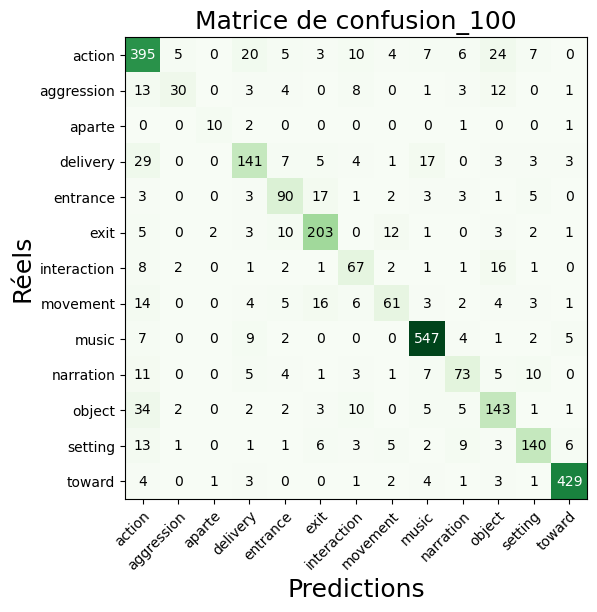

In [10]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(y_test_100, y_pred_100)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens, class_names=sorted(['entrance',
 'music',
 'interaction',
 'movement',
 'action',
 'setting',
 'exit',
 'delivery',
 'object',
 'toward',
 'narration',
 'aparte',
 'aggression']))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Réels', fontsize=18)
plt.title('Matrice de confusion_100', fontsize=18)
plt.show()

## Training on 50% of the dataset: df_050

In [11]:
df_050_train = pd.read_csv("data-common/train_050/AS13_stgdir_labelGeneric_trainvalid_50-train.csv")
df_050_valid = pd.read_csv("data-common/train_050/AS13_stgdir_labelGeneric_trainvalid_50-valid.csv")
df_050_test = pd.read_csv("data-common/train_050/AS13_stgdir_labelGeneric_trainvalid_50-test.csv")

In [12]:
X_train_050 = df_050_train[['text']]
y_train_050 = df_050_train.label
X_test_050 =df_050_test[['text']]
y_test_050 = df_050_test.label

In [13]:
models = [
    ('LogisticRegression', LogisticRegression()),
    ('RidgeClassifier', RidgeClassifier()),
     ('RandomForest', RandomForestClassifier()),
    ('SGDClassifier', SGDClassifier()
    )
]


scores = []
names = []
scoring = 'macro F1'
fold_scores = {}

for name, model in models:
    print(f"Model : {name}")
    names.append(name)
    typo2_classifier_pipeline_wf_pos_n22_charng_strlg = make_pipeline(column_trans_wf_pos_n22_charng_txtstats, model)
    typo2_classifier_pipeline_wf_pos_n22_charng_strlg.fit(X_train_050, y_train_050)
    y_pred_050 = typo2_classifier_pipeline_wf_pos_n22_charng_strlg.predict(X_test_050)
    print("Classification report:\n\n{}".format(classification_report(y_test_050, y_pred_050, digits=4)))
    f1 = metrics.f1_score(y_test_050, y_pred_050, average='macro')
    scores.append(f1)


Model : LogisticRegression
[ColumnTransformer]  (1 of 5) Processing description_tfidf, total=  10.9s
[ColumnTransformer] ........... (2 of 5) Processing pos, total=  13.7s
[ColumnTransformer] ........ (3 of 5) Processing ngrams, total=  10.0s
[ColumnTransformer] ... (4 of 5) Processing char_ngrams, total=   0.4s
[ColumnTransformer]  (5 of 5) Processing description_stats, total=   0.0s
Classification report:

              precision    recall  f1-score   support

           0     0.6544    0.8025    0.7209       486
           1     0.7647    0.3467    0.4771        75
           2     0.6667    0.1429    0.2353        14
           3     0.6585    0.5070    0.5729       213
           4     0.6129    0.5938    0.6032       128
           5     0.8378    0.7686    0.8017       242
           6     0.6944    0.4902    0.5747       102
           7     0.6585    0.4538    0.5373       119
           8     0.8660    0.9185    0.8915       577
           9     0.5887    0.6083    0.5984    

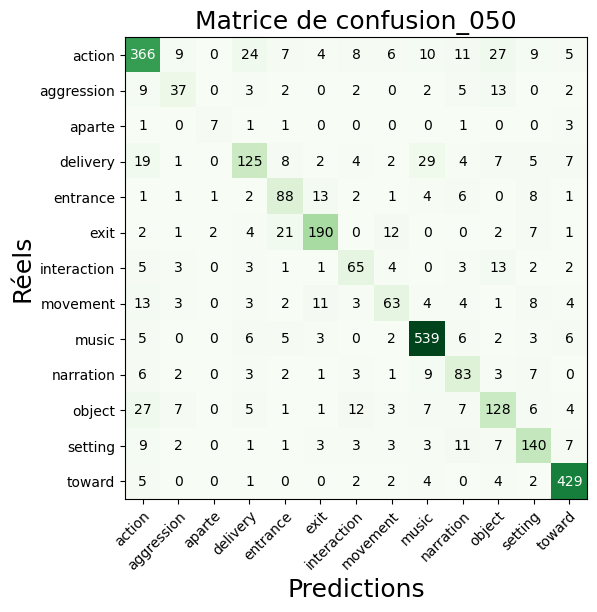

In [14]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(y_test_050, y_pred_050)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens, class_names=sorted(['entrance',
 'music',
 'interaction',
 'movement',
 'action',
 'setting',
 'exit',
 'delivery',
 'object',
 'toward',
 'narration',
 'aparte',
 'aggression']))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Réels', fontsize=18)
plt.title('Matrice de confusion_050', fontsize=18)
plt.show()

## Training on 25% of the dataset: df_025

In [15]:
df_025_train = pd.read_csv("data-common/train_025/AS13_stgdir_labelGeneric_trainvalid_25-train.csv")
df_025_valid = pd.read_csv("data-common/train_025/AS13_stgdir_labelGeneric_trainvalid_25-valid.csv")
df_025_test = pd.read_csv("data-common/train_025/AS13_stgdir_labelGeneric_trainvalid_25-test.csv")

In [16]:
X_train_025 = df_025_train[['text']]
y_train_025 = df_025_train.label
X_test_025 =df_025_test[['text']]
y_test_025 = df_025_test.label

In [17]:
models = [
    ('LogisticRegression', LogisticRegression()),
    ('RidgeClassifier', RidgeClassifier()),
     ('RandomForest', RandomForestClassifier()),
    ('SGDClassifier', SGDClassifier()
    )
]


scores = []
names = []
scoring = 'macro F1'
fold_scores = {}

for name, model in models:
    print(f"Model : {name}")
    names.append(name)
    typo2_classifier_pipeline_wf_pos_n22_charng_strlg = make_pipeline(column_trans_wf_pos_n22_charng_txtstats, model)
    typo2_classifier_pipeline_wf_pos_n22_charng_strlg.fit(X_train_025, y_train_025)
    y_pred_025 = typo2_classifier_pipeline_wf_pos_n22_charng_strlg.predict(X_test_025)
    print("Classification report:\n\n{}".format(classification_report(y_test_025, y_pred_025, digits=4)))
    f1 = metrics.f1_score(y_test_025, y_pred_025, average='macro')
    scores.append(f1)


Model : LogisticRegression
[ColumnTransformer]  (1 of 5) Processing description_tfidf, total=  10.8s
[ColumnTransformer] ........... (2 of 5) Processing pos, total=   9.5s
[ColumnTransformer] ........ (3 of 5) Processing ngrams, total=   6.2s
[ColumnTransformer] ... (4 of 5) Processing char_ngrams, total=   0.3s
[ColumnTransformer]  (5 of 5) Processing description_stats, total=   0.0s
Classification report:

              precision    recall  f1-score   support

           0     0.5932    0.7860    0.6761       486
           1     0.6667    0.1333    0.2222        75
           2     0.0000    0.0000    0.0000        14
           3     0.5241    0.4601    0.4900       213
           4     0.6293    0.5703    0.5984       128
           5     0.8491    0.7438    0.7930       242
           6     0.6622    0.4804    0.5568       102
           7     0.6852    0.3109    0.4277       119
           8     0.8910    0.8925    0.8918       577
           9     0.5234    0.5583    0.5403    

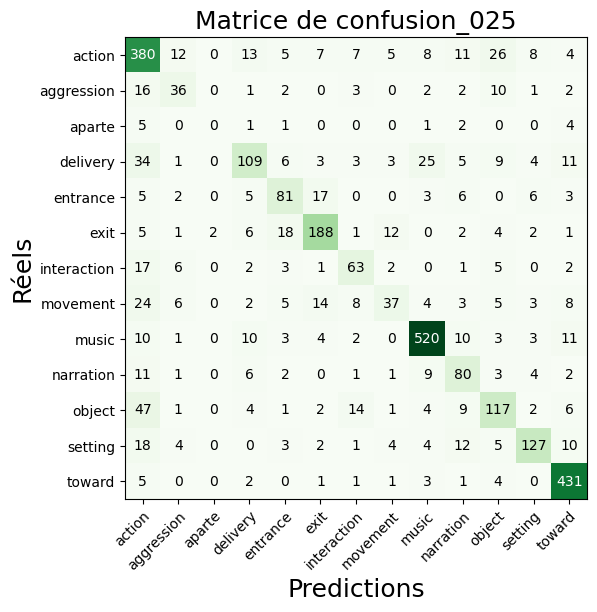

In [18]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(y_test_025, y_pred_025)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens, class_names=sorted(['entrance',
 'music',
 'interaction',
 'movement',
 'action',
 'setting',
 'exit',
 'delivery',
 'object',
 'toward',
 'narration',
 'aparte',
 'aggression']))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Réels', fontsize=18)
plt.title('Matrice de confusion_025', fontsize=18)
plt.show()

## Training on 10% of the dataset: df_010

In [19]:
df_010_train = pd.read_csv("data-common/train_010/AS13_stgdir_labelGeneric_trainvalid_10-train.csv")
df_010_valid = pd.read_csv("data-common/train_010/AS13_stgdir_labelGeneric_trainvalid_10-valid.csv")
df_010_test = pd.read_csv("data-common/train_010/AS13_stgdir_labelGeneric_trainvalid_10-test.csv")

In [20]:
X_train_010 = df_010_train[['text']]
y_train_010 = df_010_train.label
X_test_010 =df_010_test[['text']]
y_test_010 = df_010_test.label

In [21]:
models = [
    ('LogisticRegression', LogisticRegression()),
    ('RidgeClassifier', RidgeClassifier()),
     ('RandomForest', RandomForestClassifier()),
    ('SGDClassifier', SGDClassifier()
    )
]


scores = []
names = []
scoring = 'macro F1'
fold_scores = {}

for name, model in models:
    print(f"Model : {name}")
    names.append(name)
    typo2_classifier_pipeline_wf_pos_n22_charng_strlg = make_pipeline(column_trans_wf_pos_n22_charng_txtstats, model)
    typo2_classifier_pipeline_wf_pos_n22_charng_strlg.fit(X_train_010, y_train_010)
    y_pred_010 = typo2_classifier_pipeline_wf_pos_n22_charng_strlg.predict(X_test_010)
    print("Classification report:\n\n{}".format(classification_report(y_test_010, y_pred_010, digits=4)))
    f1 = metrics.f1_score(y_test_010, y_pred_010, average='macro')
    scores.append(f1)

Model : LogisticRegression
[ColumnTransformer]  (1 of 5) Processing description_tfidf, total=   7.6s
[ColumnTransformer] ........... (2 of 5) Processing pos, total=   4.5s
[ColumnTransformer] ........ (3 of 5) Processing ngrams, total=   2.6s
[ColumnTransformer] ... (4 of 5) Processing char_ngrams, total=   0.1s
[ColumnTransformer]  (5 of 5) Processing description_stats, total=   0.0s
Classification report:

              precision    recall  f1-score   support

           0     0.5099    0.7387    0.6034       486
           1     0.4500    0.1200    0.1895        75
           2     0.0000    0.0000    0.0000        14
           3     0.5000    0.2864    0.3642       213
           4     0.7083    0.3984    0.5100       128
           5     0.8276    0.6942    0.7551       242
           6     0.6386    0.5196    0.5730       102
           7     0.6111    0.0924    0.1606       119
           8     0.8605    0.8873    0.8737       577
           9     0.6078    0.5167    0.5586    

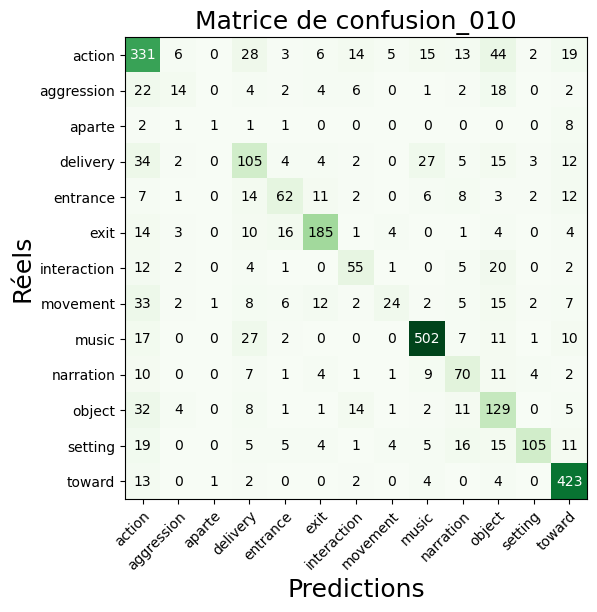

In [22]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(y_test_010, y_pred_010)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens, class_names=sorted(['entrance',
 'music',
 'interaction',
 'movement',
 'action',
 'setting',
 'exit',
 'delivery',
 'object',
 'toward',
 'narration',
 'aparte',
 'aggression']))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Réels', fontsize=18)
plt.title('Matrice de confusion_010', fontsize=18)
plt.show()

## Training on 5% of the dataset: df_005

In [23]:
df_005_train = pd.read_csv("data-common/train_005/AS13_stgdir_labelGeneric_5-train.csv")
df_005_valid = pd.read_csv("data-common/train_005/AS13_stgdir_labelGeneric_5-valid.csv")
df_005_test = pd.read_csv("data-common/train_005/AS13_stgdir_labelGeneric_5-test.csv")

In [24]:
X_train_005 = df_005_train[['text']]
y_train_005 = df_005_train.label
X_test_005 =df_005_test[['text']]
y_test_005 = df_005_test.label

In [25]:
models = [
    ('LogisticRegression', LogisticRegression()),
    ('RidgeClassifier', RidgeClassifier()),
     ('RandomForest', RandomForestClassifier()),
    ('SGDClassifier', SGDClassifier()
    )
]


scores = []
names = []
scoring = 'macro F1'
fold_scores = {}

for name, model in models:
    print(f"Model : {name}")
    names.append(name)
    typo2_classifier_pipeline_wf_pos_n22_charng_strlg = make_pipeline(column_trans_wf_pos_n22_charng_txtstats, model)
    typo2_classifier_pipeline_wf_pos_n22_charng_strlg.fit(X_train_005, y_train_005)
    y_pred_005 = typo2_classifier_pipeline_wf_pos_n22_charng_strlg.predict(X_test_005)
    print("Classification report:\n\n{}".format(classification_report(y_test_005, y_pred_005, digits=4)))
    f1 = metrics.f1_score(y_test_005, y_pred_005, average='macro')
    scores.append(f1)

Model : LogisticRegression
[ColumnTransformer]  (1 of 5) Processing description_tfidf, total=   2.0s
[ColumnTransformer] ........... (2 of 5) Processing pos, total=   2.5s
[ColumnTransformer] ........ (3 of 5) Processing ngrams, total=   1.0s
[ColumnTransformer] ... (4 of 5) Processing char_ngrams, total=   0.0s
[ColumnTransformer]  (5 of 5) Processing description_stats, total=   0.0s
Classification report:

              precision    recall  f1-score   support

           0     0.3912    0.6955    0.5007       486
           1     0.2857    0.0800    0.1250        75
           2     0.0000    0.0000    0.0000        14
           3     0.3500    0.0329    0.0601       213
           4     0.7917    0.1484    0.2500       128
           5     0.8052    0.5124    0.6263       242
           6     0.6000    0.2353    0.3380       102
           7     0.4000    0.1513    0.2195       119
           8     0.8909    0.8354    0.8623       577
           9     0.4634    0.6333    0.5352    

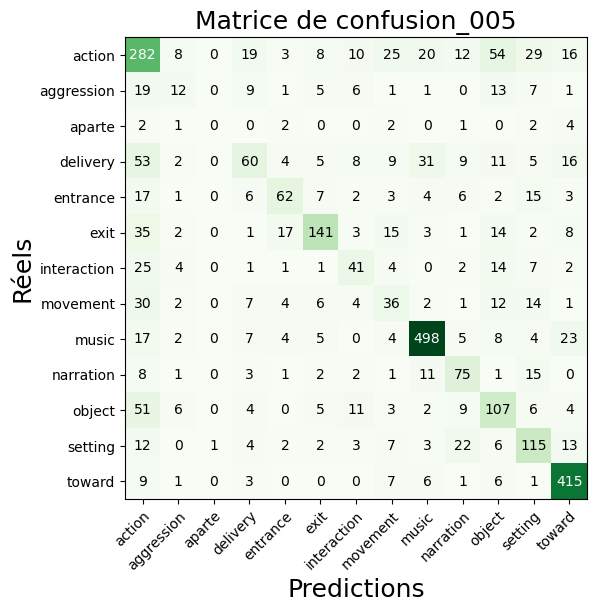

In [26]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(y_test_005, y_pred_005)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens, class_names=sorted(['entrance',
 'music',
 'interaction',
 'movement',
 'action',
 'setting',
 'exit',
 'delivery',
 'object',
 'toward',
 'narration',
 'aparte',
 'aggression']))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Réels', fontsize=18)
plt.title('Matrice de confusion_005', fontsize=18)
plt.show()